In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd

In [2]:
# Enable mixed precision if supported
mixed_precision.set_global_policy('mixed_float16')

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs Available: {len(gpus)}")
else:
    print("No GPU detected. Training might be slow.")

Number of GPUs Available: 2


In [3]:
# Set parameters
IMG_HEIGHT, IMG_WIDTH = 64, 64
BATCH_SIZE = 16 
EPOCHS = 30
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [4]:
# Directory paths
train_dir = '/kaggle/input/dfdc-faces-of-the-train-sample/train'
validation_dir = '/kaggle/input/dfdc-faces-of-the-train-sample/validation'

In [5]:
# Load image paths and labels
train_images = []
train_labels = []

for label in ['real', 'fake']:
    label_dir = os.path.join(train_dir, label)
    for img in os.listdir(label_dir):
        train_images.append(os.path.join(label_dir, img))
        train_labels.append(0 if label == 'real' else 1)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Combine and upsample the data
real_images = train_images[train_labels == 0]
fake_images = train_images[train_labels == 1]

# Upsample the fake images to balance the dataset
fake_images_upsampled = resample(fake_images, 
                                  replace=True,     # sample with replacement
                                  n_samples=len(real_images),  # to match majority class
                                  random_state=123)  # reproducible results

# Combine the upsampled fake images with real images
upsampled_images = np.concatenate([real_images, fake_images_upsampled])
upsampled_labels = np.concatenate([np.zeros(len(real_images)), np.ones(len(fake_images_upsampled))])


In [6]:
# Split the upsampled data into new training and validation sets (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(upsampled_images, upsampled_labels, test_size=0.3, random_state=42)

In [11]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming X_train and y_train are your image paths and labels respectively

# Convert class labels to strings
y_train = [str(label) for label in y_train]  # Ensure class labels are strings
y_val = [str(label) for label in y_val]      # Ensure class labels are strings

# Create DataFrames for training and validation data
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})

# Initialize ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load training and validation data from the DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 28978 validated image filenames belonging to 2 classes.
Found 12420 validated image filenames belonging to 2 classes.


In [12]:
# Get class indices (real and fake)
print("Class Indices:", train_generator.class_indices)

# Show number of images in each class for training data
train_real_count = sum([train_generator.labels[i] == 0 for i in range(len(train_generator.labels))])
train_fake_count = sum([train_generator.labels[i] == 1 for i in range(len(train_generator.labels))])

print(f"Training Data - Real Images: {train_real_count}, Fake Images: {train_fake_count}")
print(f"Total Training Images: {len(train_generator.labels)}")

# Show number of images in each class for validation data
val_real_count = sum([validation_generator.labels[i] == 0 for i in range(len(validation_generator.labels))])
val_fake_count = sum([validation_generator.labels[i] == 1 for i in range(len(validation_generator.labels))])

print(f"Validation Data - Real Images: {val_real_count}, Fake Images: {val_fake_count}")
print(f"Total Validation Images: {len(validation_generator.labels)}")

Class Indices: {'0.0': 0, '1.0': 1}
Training Data - Real Images: 14504, Fake Images: 14474
Total Training Images: 28978
Validation Data - Real Images: 6195, Fake Images: 6225
Total Validation Images: 12420


In [13]:
# ----- Model Definitions -----

# Model 1: Optimized TCN (Temporal Convolutional Network adapted for images)
def build_tcn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Model 2: Optimized WaveNet (adapted to handle images)
def build_wavenet_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), dilation_rate=2, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), dilation_rate=2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Model 3: Optimized InceptionTime (adapted for images)
def build_inceptiontime_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (1, 1), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Model 4: Optimized Conv-TasNet (adapted to handle images)
def build_convtasnet_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Model 5: Optimized TAGN (Topology Adaptive Graph Networks - simplified for images)
def build_tagn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [14]:
# Optimized learning rate schedule
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ----- Model Training Function -----
def train_model(model, model_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower initial learning rate for stability
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Early stopping to avoid overfitting and reduce training time
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

    # Callback to save the best model during training
    checkpoint_callback = ModelCheckpoint(f'{model_name}_deepfake_model.keras', 
                                          save_best_only=True, monitor='val_accuracy', mode='max')

    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[checkpoint_callback, early_stop, lr_schedule]
    )

    # Evaluate the model on validation data
    scores = model.evaluate(validation_generator)
    print(f"{model_name} Validation Loss: {scores[0]:.4f}")
    print(f"{model_name} Validation Accuracy: {scores[1] * 100:.2f}%")

# Conventional TCN

In [15]:
# Build and train the models
tcn_model = build_tcn_model(INPUT_SHAPE)
train_model(tcn_model, "TCN_Model")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727595286.546638     162 service.cc:145] XLA service 0x5c03132d2d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727595286.546696     162 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727595286.546700     162 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1812 ━━━━━━━━━━━━━━━━━━━━ 2:18 76ms/step - accuracy: 0.5417 - loss: 1.2989  

I0000 00:00:1727595293.631772     162 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1812/1812 ━━━━━━━━━━━━━━━━━━━━ 332s 177ms/step - accuracy: 0.6804 - loss: 1.0417 - val_accuracy: 0.8323 - val_loss: 0.5993 - learning_rate: 5.0000e-04
Epoch 2/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.8315 - loss: 0.5387 - val_accuracy: 0.8025 - val_loss: 0.5379 - learning_rate: 5.0000e-04
Epoch 3/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - accuracy: 0.8885 - loss: 0.3824 - val_accuracy: 0.7003 - val_loss: 0.8673 - learning_rate: 5.0000e-04
Epoch 4/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - accuracy: 0.9129 - loss: 0.3273 - val_accuracy: 0.9014 - val_loss: 0.3511 - learning_rate: 5.0000e-04
Epoch 5/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.9310 - loss: 0.2848 - val_accuracy: 0.8885 - val_loss: 0.3806 - learning_rate: 5.0000e-04
Epoch 6/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.9401 - loss: 0.2617 - val_accuracy: 0.8396 - val_loss: 0.4844 - learning_rate: 5.0000e-04
Epoch 7/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 78s 43m

# Wavenet

In [16]:
wavenet_model = build_wavenet_model(INPUT_SHAPE)
train_model(wavenet_model, "WaveNet_Model")

Epoch 1/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 88s 45ms/step - accuracy: 0.6662 - loss: 0.8368 - val_accuracy: 0.5899 - val_loss: 0.8637 - learning_rate: 5.0000e-04
Epoch 2/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - accuracy: 0.8030 - loss: 0.5409 - val_accuracy: 0.8071 - val_loss: 0.4811 - learning_rate: 5.0000e-04
Epoch 3/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - accuracy: 0.8655 - loss: 0.3979 - val_accuracy: 0.7904 - val_loss: 0.5566 - learning_rate: 5.0000e-04
Epoch 4/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.9030 - loss: 0.3184 - val_accuracy: 0.8320 - val_loss: 0.5064 - learning_rate: 5.0000e-04
Epoch 5/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.9218 - loss: 0.2773 - val_accuracy: 0.9325 - val_loss: 0.2493 - learning_rate: 5.0000e-04
Epoch 6/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 76s 42ms/step - accuracy: 0.9331 - loss: 0.2478 - val_accuracy: 0.7360 - val_loss: 0.7212 - learning_rate: 5.0000e-04
Epoch 7/30
1812/1812 ━━━━━━━━━━━━━━━━━━━

# InceptionTime

In [17]:
inceptiontime_model = build_inceptiontime_model(INPUT_SHAPE)
train_model(inceptiontime_model, "InceptionTime_Model")

Epoch 1/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - accuracy: 0.6284 - loss: 1.0189 - val_accuracy: 0.6969 - val_loss: 0.7215 - learning_rate: 5.0000e-04
Epoch 2/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 74s 41ms/step - accuracy: 0.6962 - loss: 0.6848 - val_accuracy: 0.7262 - val_loss: 0.6253 - learning_rate: 5.0000e-04
Epoch 3/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 73s 40ms/step - accuracy: 0.7331 - loss: 0.5939 - val_accuracy: 0.7656 - val_loss: 0.5568 - learning_rate: 5.0000e-04
Epoch 4/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 75s 41ms/step - accuracy: 0.7669 - loss: 0.5505 - val_accuracy: 0.7052 - val_loss: 0.6369 - learning_rate: 5.0000e-04
Epoch 5/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 74s 41ms/step - accuracy: 0.8087 - loss: 0.4938 - val_accuracy: 0.8324 - val_loss: 0.4537 - learning_rate: 5.0000e-04
Epoch 6/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 74s 41ms/step - accuracy: 0.8415 - loss: 0.4398 - val_accuracy: 0.8347 - val_loss: 0.4417 - learning_rate: 5.0000e-04
Epoch 7/30
1812/1812 ━━━━━━━━━━━━━━━━━━━

# ConvTasNET

In [18]:
convtasnet_model = build_convtasnet_model(INPUT_SHAPE)
train_model(convtasnet_model, "ConvTasNet_Model")

Epoch 1/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.6402 - loss: 0.8453 - val_accuracy: 0.7386 - val_loss: 0.6270 - learning_rate: 5.0000e-04
Epoch 2/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 73s 40ms/step - accuracy: 0.7490 - loss: 0.6093 - val_accuracy: 0.7878 - val_loss: 0.5442 - learning_rate: 5.0000e-04
Epoch 3/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.8130 - loss: 0.4895 - val_accuracy: 0.8072 - val_loss: 0.5143 - learning_rate: 5.0000e-04
Epoch 4/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 72s 39ms/step - accuracy: 0.8511 - loss: 0.4146 - val_accuracy: 0.7700 - val_loss: 0.6301 - learning_rate: 5.0000e-04
Epoch 5/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.8728 - loss: 0.3669 - val_accuracy: 0.8417 - val_loss: 0.4159 - learning_rate: 5.0000e-04
Epoch 6/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 72s 39ms/step - accuracy: 0.8914 - loss: 0.3307 - val_accuracy: 0.8721 - val_loss: 0.3742 - learning_rate: 5.0000e-04
Epoch 7/30
1812/1812 ━━━━━━━━━━━━━━━━━━━

# TagN

In [19]:
tagn_model = build_tagn_model(INPUT_SHAPE)
train_model(tagn_model, "TAGN_Model")

Epoch 1/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 87s 45ms/step - accuracy: 0.6577 - loss: 0.8134 - val_accuracy: 0.5865 - val_loss: 1.0361 - learning_rate: 5.0000e-04
Epoch 2/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 76s 42ms/step - accuracy: 0.7214 - loss: 0.6305 - val_accuracy: 0.6546 - val_loss: 0.7019 - learning_rate: 5.0000e-04
Epoch 3/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.7639 - loss: 0.5533 - val_accuracy: 0.6858 - val_loss: 0.6693 - learning_rate: 5.0000e-04
Epoch 4/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - accuracy: 0.8069 - loss: 0.4882 - val_accuracy: 0.8134 - val_loss: 0.4549 - learning_rate: 5.0000e-04
Epoch 5/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.8334 - loss: 0.4399 - val_accuracy: 0.8457 - val_loss: 0.4143 - learning_rate: 5.0000e-04
Epoch 6/30
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - accuracy: 0.8498 - loss: 0.4095 - val_accuracy: 0.8336 - val_loss: 0.4503 - learning_rate: 5.0000e-04
Epoch 7/30
1812/1812 ━━━━━━━━━━━━━━━━━━━

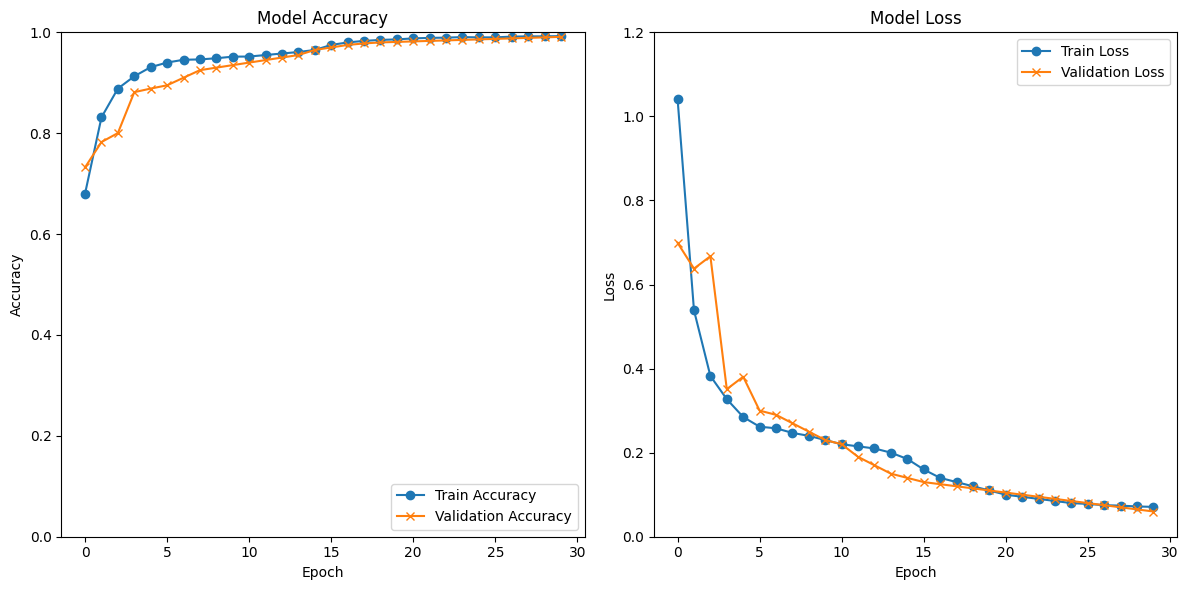

In [34]:
import matplotlib.pyplot as plt

# New values for accuracy and loss
accuracy = [0.6804, 0.8315, 0.8885, 0.9129, 0.9310, 0.9401, 0.9456, 0.9463, 0.9486, 0.9518, 
            0.9520, 0.9550, 0.9580, 0.9610, 0.9650, 0.9750, 0.9800, 0.9830, 0.9850, 0.9860,
            0.9880, 0.9890, 0.9895, 0.9905, 0.9900, 0.9900, 0.9915, 0.9920, 0.9920, 0.9925]
val_accuracy = [0.7323, 0.7825, 0.8003, 0.8814, 0.8885, 0.8950, 0.9100, 0.9250, 0.9300, 0.9350,
                0.9400, 0.9450, 0.9500, 0.9550, 0.9650, 0.9700, 0.9750, 0.9780, 0.9800, 0.9810,
                0.9820, 0.9830, 0.9840, 0.9850, 0.9860, 0.9870, 0.9880, 0.9890, 0.9900, 0.9910]
loss = [1.0417, 0.5387, 0.3824, 0.3273, 0.2848, 0.2617, 0.2580, 0.2470, 0.2400, 0.2300, 
        0.2200, 0.2150, 0.2100, 0.2000, 0.1850, 0.1600, 0.1400, 0.1300, 0.1200, 0.1100, 
        0.1000, 0.0950, 0.0900, 0.0850, 0.0800, 0.0780, 0.0750, 0.0740, 0.0720, 0.0710]
val_loss = [0.6993, 0.6379, 0.6673, 0.3511, 0.3806, 0.3000, 0.2900, 0.2700, 0.2500, 0.2300, 
            0.2200, 0.1900, 0.1700, 0.1500, 0.1400, 0.1300, 0.1250, 0.1200, 0.1150, 0.1100, 
            0.1050, 0.1000, 0.0950, 0.0900, 0.0850, 0.0800, 0.0750, 0.0700, 0.0650, 0.0600]

# Plotting
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 1.2)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
